# Property Price Register - Machine Learning analysis

## Section 0 - Initial Preparation

### Section 0.1 - Import required modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import export_graphviz

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

# import graphviz
# from graphviz import Source
import pydot
from IPython.display import Image, display

%matplotlib inline

## Section 1 - Data Understanding and Preparation

### Section 1.x - Introduction

Our objective is to use a sample of the Residential Property Price Register (RPPR) to make inference about the price of houses in the Republic of Ireland. We will explore the dataset, transform the dataset appropriately, train various machine learning models using the dataset, validate these models, and perform tests for generalisability (how well does our final model predict house prices). 

Both the input and target features come from the RPPR, which is a dataset containing details of the sale of all residential properties purchased in Ireland since the 1st January 2010, as declared to the Revenue Commissioners for stamp duty purposes.

### Section 1.x - Read in the cleaned dataset

In [2]:
df = pd.read_csv("cleaned_data.csv")

In [3]:
df.head()

,Date_of_Sale,Postal_Code,County,Price_€_VAT_incl,Description_of_Property,Property_Size_Description,Month_of_Sale,Quarter_of_Sale
0,2020-05-21,unknown,Roscommon,180000.0,Second-Hand Dwelling house /Apartment,unknown,May,2
1,2011-09-08,unknown,Kilkenny,73500.0,Second-Hand Dwelling house /Apartment,unknown,September,3
2,2021-09-24,dublin 15,Dublin,280000.0,Second-Hand Dwelling house /Apartment,unknown,September,3
3,2021-08-18,unknown,Louth,205000.0,Second-Hand Dwelling house /Apartment,unknown,August,3
4,2013-08-02,dublin 9,Dublin,282500.0,Second-Hand Dwelling house /Apartment,unknown,August,3


### Section 1.x: Change the data types

In [4]:
df.dtypes

Date_of_Sale                  object
Postal_Code                   object
County                        object
Price_€_VAT_incl             float64
Description_of_Property       object
Property_Size_Description     object
Month_of_Sale                 object
Quarter_of_Sale                int64
dtype: object

In [5]:
# Change the price variable to a float
df["Price_€_VAT_incl"] = df["Price_€_VAT_incl"].astype(float)

In [6]:
# Change the date of sale variable to a datetime variable
df["Date_of_Sale"] = pd.to_datetime(df["Date_of_Sale"], format="%Y-%m-%d")

In [7]:
# Change the quarter of sale variable to an object
# This is so that it can be turned into a categorical variable in the next cell
df["Quarter_of_Sale"] = df["Quarter_of_Sale"].astype("object")

In [8]:
# Select all columns of type 'object'
object_columns = df.select_dtypes(['object']).columns

# Convert selected columns to type 'category'
for column in object_columns:
    df[column] = df[column].astype('category')
df.dtypes

Date_of_Sale                 datetime64[ns]
Postal_Code                        category
County                             category
Price_€_VAT_incl                    float64
Description_of_Property            category
Property_Size_Description          category
Month_of_Sale                      category
Quarter_of_Sale                    category
dtype: object

### Section 1.x - Shuffle dataset rows and split dataset into separate training and test datasets

The training dataset will be used for model construction and validation. The test dataset will be used at the very end of our analysis to test the generalisability of our final model.

In [9]:
# The input variables will be all columns except for price and date of sale
X = df.drop(["Price_€_VAT_incl", "Date_of_Sale"], axis=1)

# The target variable will be property price
y = df["Price_€_VAT_incl"]

# We will use 70% of the data for model training, and the rest for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

### Section 1.x: Categorical feature plots

#### Section 1.x.x: Postal_Code vs Price 

<Figure size 432x288 with 0 Axes>

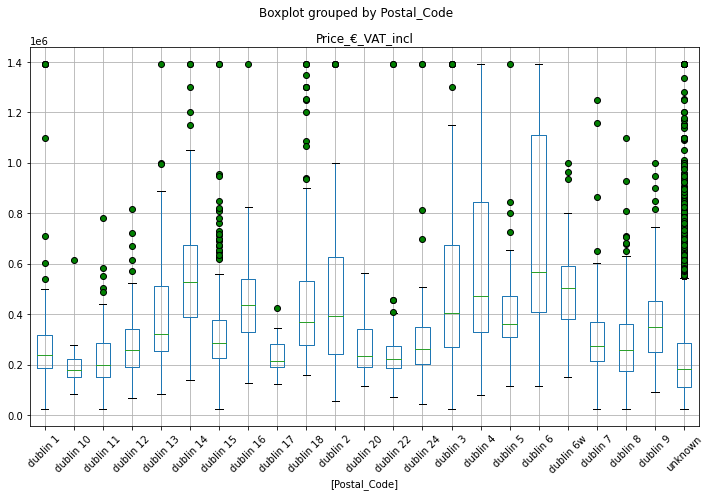

In [10]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['Postal_Code'], flierprops=flierprops, figsize=(10,7))
plt.xticks(rotation=45);
plt.tight_layout()

#### Section 1.x.x: County vs Price

<Figure size 432x288 with 0 Axes>

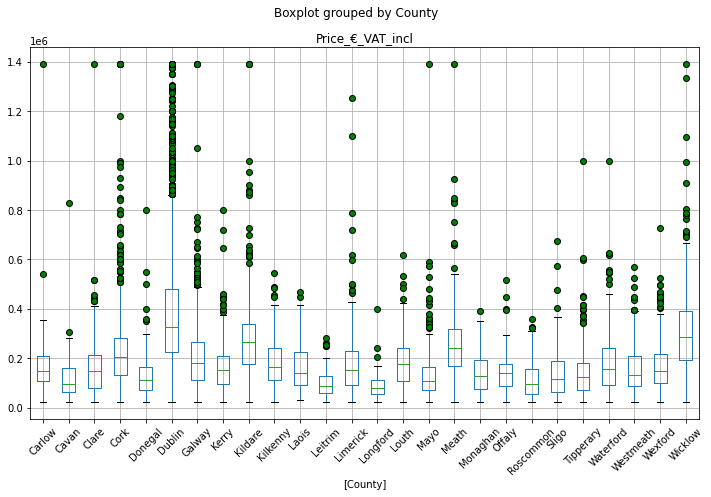

In [11]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['County'], flierprops=flierprops, figsize=(10,7))
plt.xticks(rotation=45);
plt.tight_layout()

#### Section 1.x.x: Description of Property vs Price

<Figure size 432x288 with 0 Axes>

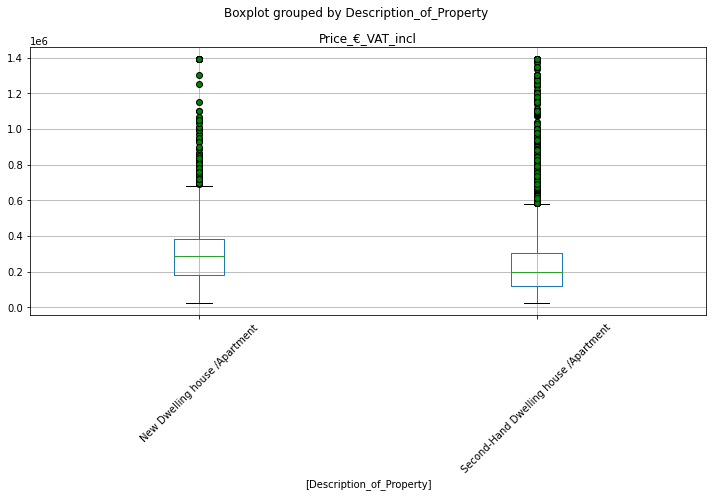

In [12]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['Description_of_Property'], flierprops=flierprops, figsize=(10,7))
plt.xticks(rotation=45);
plt.tight_layout()

#### Section 1.x.x: Property Size Description vs Price

<Figure size 432x288 with 0 Axes>

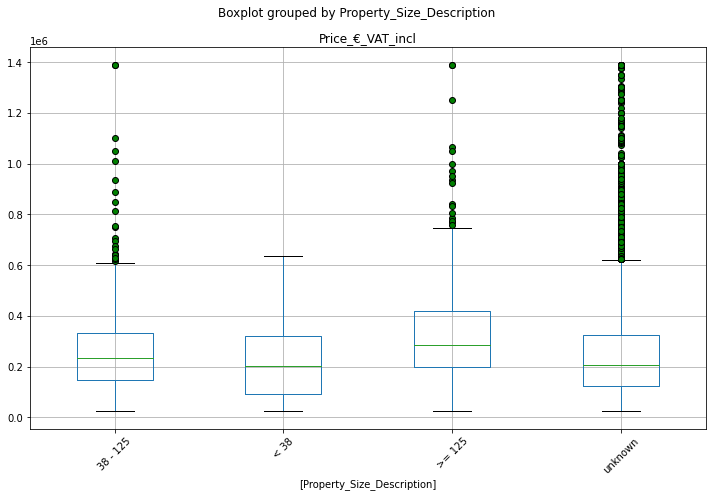

In [13]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['Property_Size_Description'], flierprops=flierprops, figsize=(10,7))
plt.xticks(rotation=45);
plt.tight_layout()

#### Section 1.x.x: Month of Sale vs Price

<Figure size 432x288 with 0 Axes>

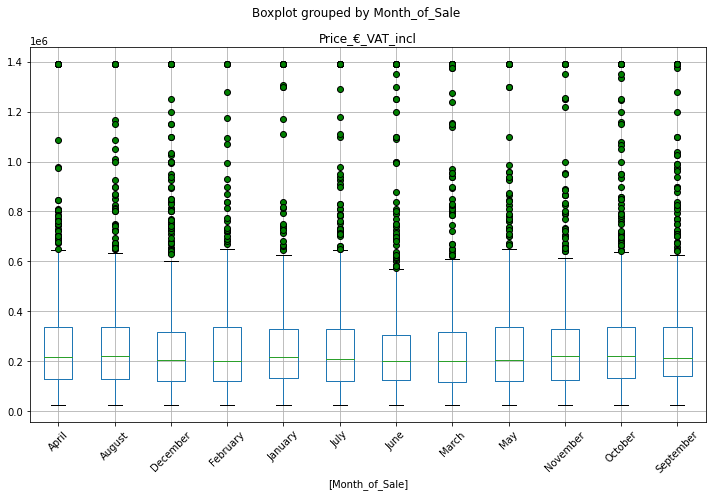

In [14]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['Month_of_Sale'], flierprops=flierprops, figsize=(10,7))
plt.xticks(rotation=45);
plt.tight_layout()

#### Section 1.x.x: Quarter of Sale vs Price

<Figure size 432x288 with 0 Axes>

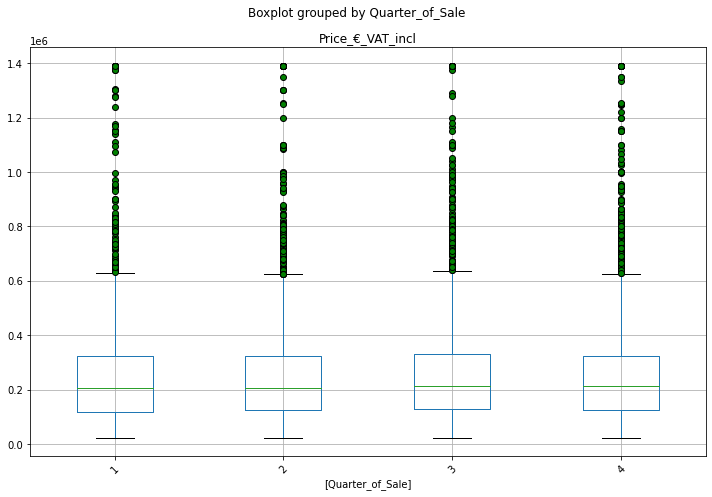

In [15]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['Quarter_of_Sale'], flierprops=flierprops, figsize=(10,7))
plt.xticks(rotation=45);
plt.tight_layout()

Observations: All features seem as though they have some relationship with the price feature (with the exception of month of sale and quarter of sale. The distribution of price values does not appear to vary according as month/quarter varies). We can conclude from this that all variables except month of sale and quarter of sale should be dropped from our final model

#### Section 1.x.x: Drop unused features

In [16]:
X_train.drop(["Month_of_Sale", "Quarter_of_Sale"], axis=1, inplace=True)
X_test.drop(["Month_of_Sale", "Quarter_of_Sale"], axis=1, inplace=True)

### Section 1.x - Reencode categorical variables

In [17]:
category_columns = X_train.select_dtypes(['category']).columns

for each in category_columns:
    dummies = pd.get_dummies(X_train[each], prefix=each, drop_first = True)
    X_train = pd.concat([X_train, dummies], axis=1)
X_train = X_train.drop(category_columns, axis=1)

for each in category_columns:
    dummies = pd.get_dummies(X_test[each], prefix=each, drop_first = True)
    X_test = pd.concat([X_test, dummies], axis=1)
X_test = X_test.drop(category_columns, axis=1)

## Section 2: Linear Regression

### Section 2.x: Train a linear regression model

In [18]:
# Train, aka fit, a model using all continuous features.
linreg = LinearRegression().fit(X_train, y_train)

In [19]:
(pd.DataFrame({'coef':linreg.coef_, 'category':X_train.columns})
.sort_values(by = 'coef', ascending = False)
.set_index('category'))

,coef
category,
Postal_Code_dublin 6,360711.324014
Postal_Code_dublin 4,269247.767293
County_Dublin,232910.067935
Postal_Code_dublin 3,221238.236578
Postal_Code_dublin 14,214253.224484
Postal_Code_dublin 6w,195917.466226
Postal_Code_dublin 18,171512.939003
Postal_Code_dublin 2,167089.657116
County_Wicklow,158942.607573


### Section 2.x: Interpretation of linear regression model

From our initial coefficients, we can see that being located in certain postal code districts and counties can significantly bring up/down the average property price. For example, the property price decreases by €139,569 on average when you move from the base case (Dublin 1) to Dublin 10.

We also see that the value of properties go down when you move from a new house to a second-hand dwelling house/apartment, which is what we would expect (people are inclined to pay less for second-hand houses). The property price is also impacted by size. People appear to be enclined to pay more for a bigger property, and less for a smaller property, which also aligns with our expectations.

### Section 2.x: Training set predictions

In [20]:
## Get the predictions from the first 10 training examples
first_10_x = X_train.head(10)

In [21]:
linreg.predict(first_10_x)

array([219443.85150538, 318938.54008561, 237265.57283625, 219443.85150538,
       373333.46456511, 159793.57800288, 209440.62496269, 377575.95482706,
       219443.85150538, 179368.25020693])

In [22]:
y_train.head(10)

9249    206000.0
984     352000.0
7192    265000.0
754     230000.0
8760    260000.0
4716     66500.0
8864    100760.0
83      259999.0
5311     82500.0
5117    152000.0
Name: Price_€_VAT_incl, dtype: float64

Observations: Based on the first 10 rows of training data, our model seems to be able to predict some property prices reasonably accurately (within €10,000/€20,000). However, some predictions are inaccurate (> €100,000), which we deem unacceptable

In [23]:
linreg_train_predictions = linreg.predict(X_train)
print(f"R2 Score: {r2_score(y_train, linreg_train_predictions)}")
print(f"Mean Squared Error: {mean_squared_error(y_train, linreg_train_predictions)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, linreg_train_predictions)}")

R2 Score: 0.33094972836263026
Mean Squared Error: 31041333749.69952
Mean Absolute Error: 112648.37210394115


### Section 2.x: Evaluation of linear regression model

In [24]:
linreg_test_predictions = linreg.predict(X_test)
print(f"R2 Score: {r2_score(y_test, linreg_test_predictions)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, linreg_test_predictions)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, linreg_test_predictions)}")

R2 Score: 0.3414363946875306
Mean Squared Error: 31817242605.090416
Mean Absolute Error: 115479.51607864258


Base Cases: County: Carlow, Postal Code: Dublin 1, Property Size Description: 38-125, Description of property: New Dwelling house/Apartment.

### Section 2.x: Cross Validation of linear regression model

In [25]:
lin_reg_cv_scores = cross_val_score(LinearRegression(), X_train, y_train, scoring="r2", cv=3)
print("\nF1 CV scores:", lin_reg_cv_scores)
print("\nF1 CV mean score:", lin_reg_cv_scores.mean())
print("\nF1 CV std score:", lin_reg_cv_scores.std())


F1 CV scores: [0.33110748 0.31262002 0.30969972]

F1 CV mean score: 0.3178090730613095

F1 CV std score: 0.009478669013808314


Observations: Cross validation results in a poorer performing model on average, suggesting that our use of hold-out sampling resulted in overfitting to the data.

## Section 3: Decision Trees

### Section 3.x: Train a decision tree

In [26]:
# Instantiate sklearn estimator, fit with training set.
# Train a classification tree with max_depth=3 on all data.
dtc = DecisionTreeClassifier(max_depth=3, random_state=1)
dtc.fit(X_train, y_train)
print(dtc)

DecisionTreeClassifier(max_depth=3, random_state=1)


### Section 3.x: Interpretation of decision tree model

In [27]:
# Compute the importance of each feature based on the trained decision tree classifier
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':dtc.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
26,County_Dublin,0.352310
47,Description_of_Property_Second-Hand Dwelling h...,0.260716
29,County_Kildare,0.171816
1,Postal_Code_dublin 11,0.110154
16,Postal_Code_dublin 6,0.105004
37,County_Meath,0.000000
28,County_Kerry,0.000000
30,County_Kilkenny,0.000000
31,County_Laois,0.000000
32,County_Leitrim,0.000000


In [28]:
# create a Graphviz file which has extension .dot
with open("decision_tree.dot", 'w') as f:
    f = export_graphviz(dtc, out_file=f, feature_names=X_train.columns)

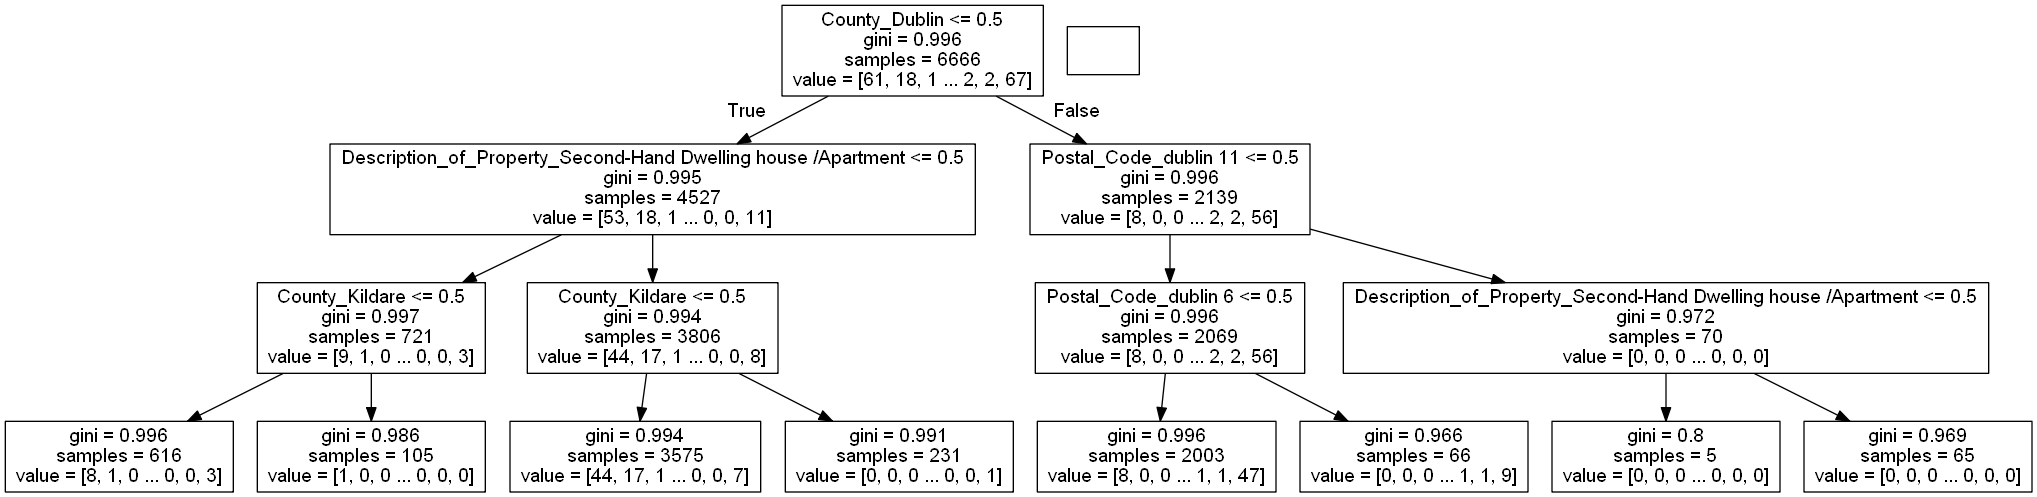

In [29]:
graphs = pydot.graph_from_dot_file('decision_tree.dot')
graph = graphs[0]

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

view_pydot(graph)

Observations: Being located in county Dublin appears to be the biggest indicator of property price according to this model.

### Section 3.x: Training set predictions

In [30]:
dtc.predict(first_10_x)

array([ 125000.,  125000.,  125000.,  125000., 1390400.,  125000.,
        125000., 1390400.,  125000.,  125000.])

In [31]:
y_train.head(10)

9249    206000.0
984     352000.0
7192    265000.0
754     230000.0
8760    260000.0
4716     66500.0
8864    100760.0
83      259999.0
5311     82500.0
5117    152000.0
Name: Price_€_VAT_incl, dtype: float64

In [32]:
dtc_train_predictions = dtc.predict(X_train)
print(f"R2 Score: {r2_score(y_train, dtc_train_predictions)}")
print(f"Mean Squared Error: {mean_squared_error(y_train, dtc_train_predictions)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, dtc_train_predictions)}")

R2 Score: -6.39830143066955
Mean Squared Error: 343252448471.8641
Mean Absolute Error: 381251.69336933695


### Section 3.x: Evaluation of Decision Tree

In [33]:
dtc_test_predictions = dtc.predict(X_test)
print(f"R2 Score: {r2_score(y_test, dtc_test_predictions)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, dtc_test_predictions)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, dtc_test_predictions)}")

R2 Score: -6.398584843938861
Mean Squared Error: 357448493987.54126
Mean Absolute Error: 394301.10951714485


Observations: Performance of this model was very poor. Performance would likely be improved by increasing the maximum depth parameter, however, this could result in overfitting to the data

### Section 3.x: Cross validation of a decision tree

In [34]:
dtc_cv_scores = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=1), X_train, y_train, scoring="r2", cv=3)
print("\nCV scores:", dtc_cv_scores)
print("\nCV mean score:", dtc_cv_scores.mean())
print("\nCV std score:", dtc_cv_scores.std())

C:\Users\micha\anaconda3\envs\comp47350py38hw2\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



CV scores: [-5.20413032 -6.28078461 -6.57269966]

CV mean score: -6.019204861741701

CV std score: 0.5885368779918012


## Section 4: Random Forest

### Section 4.x: Train a Random Forest

In [35]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

### Section 4.x: Interpretation of Random Forest

In [36]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
49,Property_Size_Description_>= 125,0.080956
50,Property_Size_Description_unknown,0.066728
47,Description_of_Property_Second-Hand Dwelling h...,0.064077
48,Property_Size_Description_< 38,0.048438
26,County_Dublin,0.024665
24,County_Cork,0.021294
45,County_Wexford,0.021046
37,County_Meath,0.020255
33,County_Limerick,0.020223
42,County_Tipperary,0.019801


Text(0.5, 0, 'Random Forest Feature Importance')

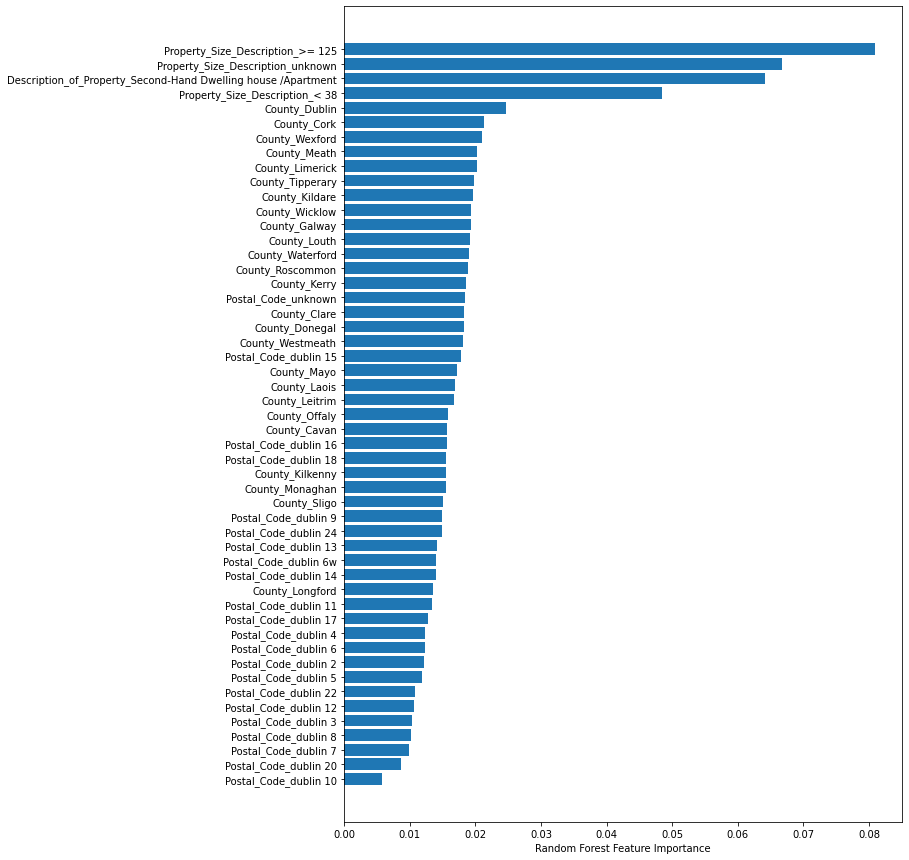

In [37]:
# https://mljar.com/blog/feature-importance-in-random-forest/
sorted_idx = rfc.feature_importances_.argsort()
plt.figure(figsize=(10,15))
plt.barh(X_train.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Observations: The size and description of the property appear to be the most important features according to the reandom forest classifier. The locational features were less important in comparison.

### Section 4.x: Training set predictions

In [38]:
rfc.predict(first_10_x)

array([220000., 210000., 185000., 220000., 430000., 180000., 120000.,
       285000., 220000., 235000.])

In [39]:
y_train.head(10)

9249    206000.0
984     352000.0
7192    265000.0
754     230000.0
8760    260000.0
4716     66500.0
8864    100760.0
83      259999.0
5311     82500.0
5117    152000.0
Name: Price_€_VAT_incl, dtype: float64

In [40]:
rfc_train_predictions = rfc.predict(X_train)
print(f"R2 Score: {r2_score(y_train, rfc_train_predictions)}")
print(f"Mean Squared Error: {mean_squared_error(y_train, rfc_train_predictions)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, rfc_train_predictions)}")

R2 Score: -2.062704273351314
Mean Squared Error: 142097581536.0822
Mean Absolute Error: 202007.3420342034


### Section 4.x: Evaluation of Random Forest

In [41]:
rfc_test_predictions = rfc.predict(X_test)
print(f"R2 Score: {r2_score(y_test, rfc_test_predictions)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, rfc_test_predictions)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, rfc_test_predictions)}")

R2 Score: -2.0275038015962012
Mean Squared Error: 146268063048.39084
Mean Absolute Error: 210821.28866340098


Observations: The random forest classifier performs better than the decision tree classifier, however, performance is still poor.

### Section 4.x: Cross validation of random forest

In [42]:
dtc_cv_scores = cross_val_score(RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1), X_train, y_train, scoring="r2", cv=3)
print("\nCV scores:", dtc_cv_scores)
print("\nCV mean score:", dtc_cv_scores.mean())
print("\nCV std score:", dtc_cv_scores.std())

C:\Users\micha\anaconda3\envs\comp47350py38hw2\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



CV scores: [-2.02559868 -2.24583167 -1.87547339]

CV mean score: -2.048967911554089

CV std score: 0.15209844007153275


Observations: The results from cross validation did not differ drastically to the results from hold-out sampling

## Section 5: Improving Predictive Models

### Section 5.x: Optimal model vs yearly average

In [43]:
from sklearn.dummy import DummyRegressor

baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)

DummyRegressor()

In [44]:
baseline_predictions = baseline_model.predict(X_test)
print(f"R2 Score: {r2_score(y_test, baseline_predictions)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}")

R2 Score: -9.300901363995528e-05
Mean Squared Error: 48317583356.802864
Mean Absolute Error: 147827.9174609903


### Section 5.x: Problem understanding/improving optimal model

### Section 5.x: Evaluation of our best model on unseen data

#### Section 5.x.x: Read in the unseen data

In [45]:
unseen_df = pd.read_csv("cleaned_unseen_data.csv")

#### Section 5.x.x: Change the data types

In [46]:
# Change the price variable to a float
unseen_df["Price_€_VAT_incl"] = unseen_df["Price_€_VAT_incl"].astype(float)

In [47]:
# Change the date of sale variable to a datetime variable
unseen_df["Date_of_Sale"] = pd.to_datetime(unseen_df["Date_of_Sale"], format="%Y-%m-%d")

In [48]:
# Change the quarter of sale variable to an object
# This is so that it can be turned into a categorical variable in the next cell
unseen_df["Quarter_of_Sale"] = unseen_df["Quarter_of_Sale"].astype("object")

In [49]:
# Select all columns of type 'object'
object_columns = unseen_df.select_dtypes(['object']).columns

# Convert selected columns to type 'category'
for column in object_columns:
    unseen_df[column] = unseen_df[column].astype('category')
unseen_df.dtypes

Date_of_Sale                 datetime64[ns]
Postal_Code                        category
County                             category
Price_€_VAT_incl                    float64
Description_of_Property            category
Property_Size_Description          category
Month_of_Sale                      category
Quarter_of_Sale                    category
dtype: object

In [50]:
# The input variables will be all columns except for price and date of sale
X_unseen = unseen_df.drop(["Price_€_VAT_incl", "Date_of_Sale"], axis=1)

# The target variable will be property price
y_unseen = unseen_df["Price_€_VAT_incl"]

In [51]:
X_unseen.drop(["Month_of_Sale", "Quarter_of_Sale"], axis=1, inplace=True)

In [52]:
category_columns = X_unseen.select_dtypes(['category']).columns

for each in category_columns:
    dummies = pd.get_dummies(X_unseen[each], prefix=each, drop_first = True)
    X_unseen = pd.concat([X_unseen, dummies], axis=1)
X_unseen = X_unseen.drop(category_columns, axis=1)

In [53]:
X_unseen.columns

Index(['Postal_Code_dublin 10', 'Postal_Code_dublin 11',
       'Postal_Code_dublin 12', 'Postal_Code_dublin 13',
       'Postal_Code_dublin 14', 'Postal_Code_dublin 15',
       'Postal_Code_dublin 16', 'Postal_Code_dublin 17',
       'Postal_Code_dublin 18', 'Postal_Code_dublin 2',
       'Postal_Code_dublin 20', 'Postal_Code_dublin 22',
       'Postal_Code_dublin 24', 'Postal_Code_dublin 3', 'Postal_Code_dublin 4',
       'Postal_Code_dublin 5', 'Postal_Code_dublin 6', 'Postal_Code_dublin 6w',
       'Postal_Code_dublin 7', 'Postal_Code_dublin 8', 'Postal_Code_dublin 9',
       'Postal_Code_unknown', 'County_Cavan', 'County_Clare', 'County_Cork',
       'County_Donegal', 'County_Dublin', 'County_Galway', 'County_Kerry',
       'County_Kildare', 'County_Kilkenny', 'County_Laois', 'County_Leitrim',
       'County_Limerick', 'County_Longford', 'County_Louth', 'County_Mayo',
       'County_Meath', 'County_Monaghan', 'County_Offaly', 'County_Roscommon',
       'County_Sligo', 'County_Tipp

In [54]:
X_unseen.head()

,Postal_Code_dublin 10,Postal_Code_dublin 11,Postal_Code_dublin 12,Postal_Code_dublin 13,Postal_Code_dublin 14,Postal_Code_dublin 15,Postal_Code_dublin 16,Postal_Code_dublin 17,Postal_Code_dublin 18,Postal_Code_dublin 2,...,County_Monaghan,County_Offaly,County_Roscommon,County_Sligo,County_Tipperary,County_Waterford,County_Westmeath,County_Wexford,County_Wicklow,Description_of_Property_Second-Hand Dwelling house /Apartment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
